# CSE327 Programming Practice 3
**Due date: 23:59 on May 16, 2019 (Thursday)**

## Description
---
In this programming practice, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this PP you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this PP with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.

Under your downloaded folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the Google Classroom won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.
## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools


import time
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
# from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


In [2]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
test_num = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

The accuracy of my dummy model is 5.33%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [114]:
train_feat = np.zeros((train_num, 256))
test_feat = np.zeros((test_num, 256))
for i in range(train_num):
    train_feat[i] = cv2.resize(train_data[i], dsize = (16,16), interpolation=cv2.INTER_AREA).reshape(256,)
    train_feat[i] -= np.mean(train_feat[i])
for i in xrange(test_num):
    test_feat[i] = cv2.resize(test_data[i], dsize= (16,16), interpolation=cv2.INTER_AREA).reshape(256,)
    test_feat[i] -= np.mean(train_feat[i])
nearN  = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2).fit(train_feat, train_label)
test_pred = nearN.predict(test_feat)

accuracy = np.sum(test_pred == test_label) / float(test_num)
print "The accuracy of tiny images model is {:.2f}%".format(accuracy*100)


The accuracy of tiny images model is 19.27%


In [129]:
# Write your codes here

def train_and_test_C1():
    train_feat = np.zeros((train_num, 256))
    test_feat = np.zeros((test_num, 256))
    for i in range(train_num):
        train_feat[i] = cv2.resize(train_data[i], dsize = (16,16), interpolation=cv2.INTER_AREA).reshape(256)
        train_feat[i] -= np.mean(train_feat[i])
    for i in xrange(test_num):
        test_feat[i] = cv2.resize(test_data[i], dsize= (16,16), interpolation=cv2.INTER_AREA).reshape(256)
        test_feat[i] -= np.mean(test_feat[i])
#     nearN  = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2).fit(train_feat, train_label)
#     test_pred = nearN.predict(test_feat)
    #predict
    nearN = NearestNeighbors(n_neighbors=1, algorithm="auto", p=2).fit(train_feat) #euclidean_distance (l2)
    distances, index = nearN.kneighbors(test_feat)
    pred1 = []
    for i in index:
        ind = int(i)
        pred1.append(train_label[ind])
    accuracy = sum(np.array(pred1) == test_label) / float(test_num)
    print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))
    return pred1, test_label

start = time.clock()
pred1, label1 = train_and_test_C1()
end = time.clock()
print("Training and testing time is ", end-start, "s")



The accuracy of my dummy model is 20.20%
('Training and testing time is ', 1.765375907310954, 's')


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [82]:
sift = cv2.SIFT()
descriptors_by_photo_train =[]
alldescriptors_train = []
for i in xrange(train_num):
    image = train_data[i]
    keypoint = [cv2.KeyPoint(x, y, step_sizes) for y in xrange(int(step_sizes/2), w - int(step_sizes/2), step_sizes)  
                                            for x in xrange(0, h - int(step_sizes/2), step_sizes)]
    keypoint, des = sift.compute(image, kp)
#     keypoint, descriptor = sift.detectAndCompute(image, None)
    descriptors_by_photo_train.append(descriptor)
    alldescriptors_train.extend(descriptor)
    # collect descriptor of train

In [86]:
K = 200
kmeans = MiniBatchKMeans(n_clusters=K)
kmeans.fit(np.array(alldescriptors_train)) 

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=200, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [87]:
train_bag_frequency = np.zeros((train_num, K))

for i in xrange(train_num):
    predicts = kmeans.predict(descriptors_by_photo_train[i])
    for predN in predicts:
        if predN <= K:
            train_bag_frequency[i][predN] = train_bag_frequency[i][predN] + 1

In [88]:
test_bag_frequency =  np.zeros((test_num, K))
descriptors_by_photo_test = []
for i in xrange(test_num):
    image = test_data[i]
    keypoint, descriptor = sift.detectAndCompute(image, None)
    descriptors_by_photo_test.append(descriptor)
    predicts = kmeans.predict(descriptors_by_photo_test[i])
    for predN in predicts:
        if predN <= K:
            test_bag_frequency[i][predN] = test_bag_frequency[i][predN] + 1

In [61]:
# max = 200
# for i in range(train_num):
#     predict = kmeans.predict(den_sample_train[i])
#     for p in predict:
#         if max < p:
#             max = p
# print(max)

200


In [104]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 19, weights ='distance', p= 2)
neigh.fit(train_bag_frequency, train_label)

test_pred = neigh.predict(test_bag_frequency)

accuracy = np.sum(test_pred == test_label) / float(test_num)

print("The accuracy of bag model is {:.2f}%".format(accuracy*100))


The accuracy of bag model is 44.20%


In [109]:
from sklearn.neighbors import KNeighborsClassifier
K =200
step_sizes = 10
count = 0
alldescriptors_train = []
descriptors_by_photo_train = []
descriptors_by_photo_test = []

train_feat_bag = np.zeros((train_num, K))
test_feat_bag = np.zeros((test_num, K))
# make a bag of visual words

def train_and_test_C2():
    sift = cv2.SIFT()
    
    for i in xrange(train_num):
        image = train_data[i]
        keypoint = [cv2.KeyPoint(x, y, step_sizes) for y in xrange(int(step_sizes/2), w - int(step_sizes/2), step_sizes)  
                                            for x in xrange(0, h - int(step_sizes/2), step_sizes)]
        keypoint, descriptor = sift.compute(image, keypoint)
        
#         keypoint, descriptor = sift.detectAndCompute(image, None)
        descriptors_by_photo_train.append(descriptor)
        alldescriptors_train.extend(descriptor)
    # collect descriptor of train

    kmeans = MiniBatchKMeans(n_clusters=k)
    kmeans.fit(np.array(alldescriptors_train))
    # get model of kmeans

    for i in xrange(train_num):
        predicts = kmeans.predict(descriptors_by_photo_train[i])
        for predN in predicts:
            if predN <= K:
                train_bag_frequency[i][predN] = train_bag_frequency[i][predN] + 1

               
    # get the frequency of predictions

    for i in xrange(test_num):
        image = test_data[i]
        keypoint = [cv2.KeyPoint(x, y, step_sizes) for y in xrange(int(step_sizes/2), w - int(step_sizes/2), step_sizes)  
                                            for x in xrange(0, h - int(step_sizes/2), step_sizes)]
        keypoint, descriptor = sift.compute(image, keypoint)
#         keypoint, descriptor = sift.detectAndCompute(image, None)
        descriptors_by_photo_test.append(descriptor)
        predicts = kmeans.predict(descriptors_by_photo_test[i])
        for predN in predicts:
            if predN <= K:
                test_bag_frequency[i][predN] = test_bag_frequency[i][predN] + 1
            test_bag_frequency[i]
    # get the frequency of predictions       
    
#     #predict
#     nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(train_bag_frequency)
#     distances, indices = nbrs.kneighbors(test_bag_frequency)
#     pred2 = [train_label[int(i)] for i in indices]
#     #print
#     accuracy = sum(np.array(pred2) == test_label) / float(test_num)
#     print("The accuracy of bag model is {:.2f}%".format(accuracy*100))

    neigh = KNeighborsClassifier(n_neighbors = 19, weights ='distance', p= 2)
    neigh.fit(train_bag_frequency, train_label)

    pred2 = neigh.predict(test_bag_frequency)

    accuracy = np.sum(pred2 == test_label) / float(test_num)

    print("The accuracy of bag model is {:.2f}%".format(accuracy*100))

    return pred2, test_label
    
train_feat_bag = np.zeros((train_num, k))
test_feat_bag = np.zeros((test_num, k))
start = time.clock()
pred2, label2 = train_and_test_C2()
end = time.clock()
print("Training and testing time is ", end-start, 's') 

The accuracy of bag model is 54.87%
('Training and testing time is ', 752.2340168825758, 's')


In [150]:
print(test_bag_frequency[0,1])
print(test_bag_frequency[0,2])
print(predicts.shape)
print(test_bag_frequency[0,1]/predicts.shape)

3.0261538461538464
8.0
(788L,)
[0.0038403]


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [170]:
def train_and_test_C3():
    path = SVC(C=2, gamma=0.0001, decision_function_shape ='ovr').fit(train_bag_frequency, train_label)
    predictions = path.predict(test_bag_frequency)
    accuracy = sum(np.array(predictions) == test_label) / float(test_num)
    print "The accuracy of my SVC model is {:.2f}%".format(accuracy*100)

    return predictions, test_label

start = time.clock()
pred3, label3 = train_and_test_C3()
end = time.clock()
print("Training and testing time(using existing features) is ", end-start, "s")
# print_confusion_matrix(test_label, train_label)

The accuracy of my SVC model is 68.67%
('Training and testing time(using existing features) is ', 3.8141459018843307, 's')


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

**First combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

**Second combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

**Third combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

Normalized Confusion Matrix


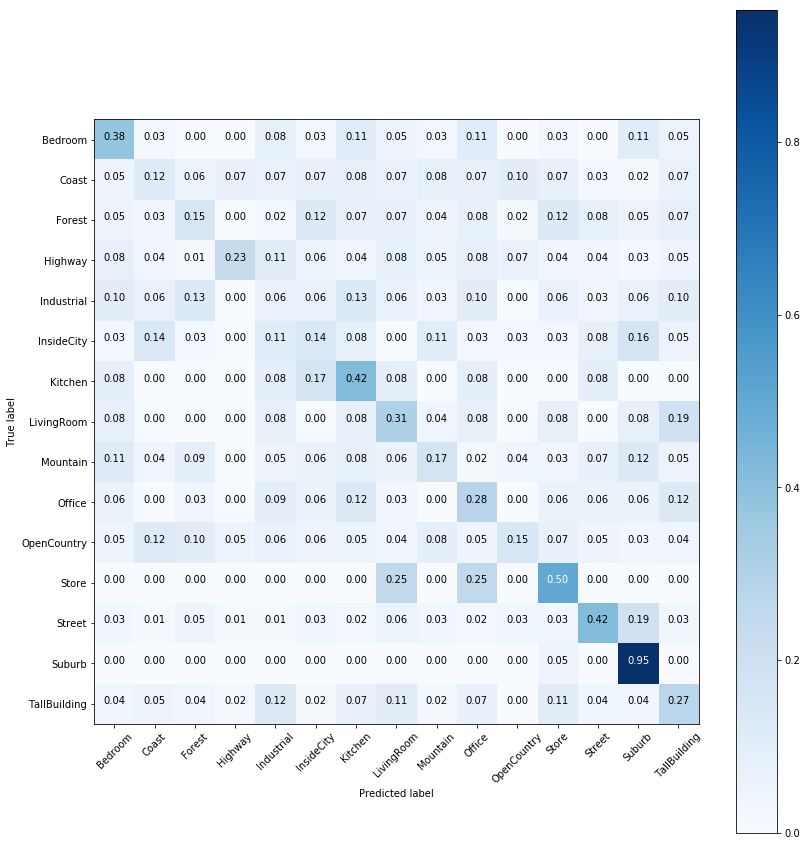

Normalized Confusion Matrix


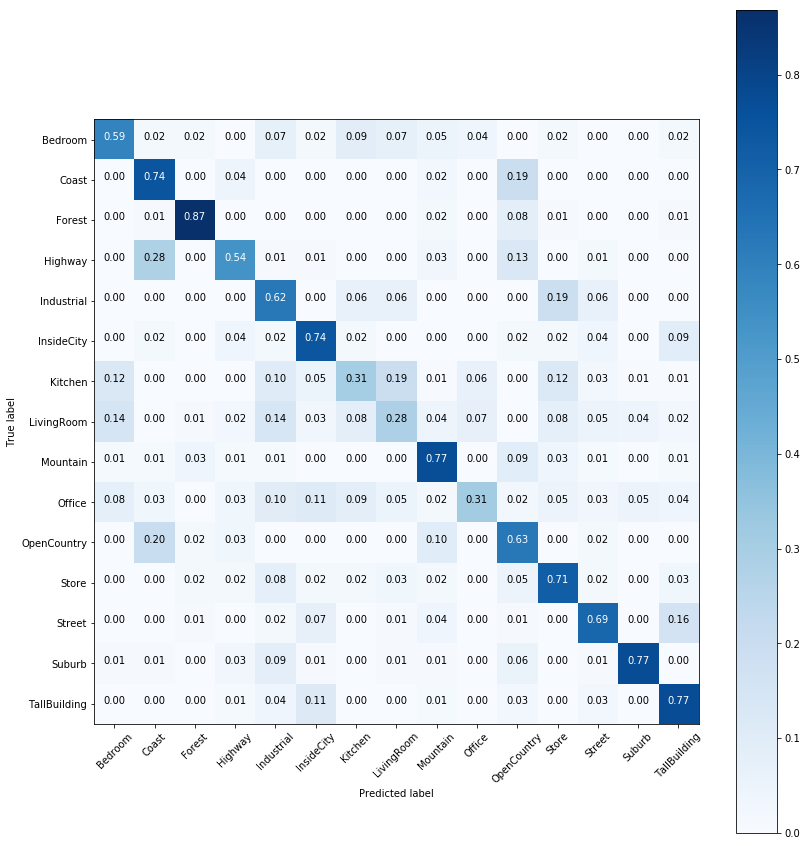

Normalized Confusion Matrix


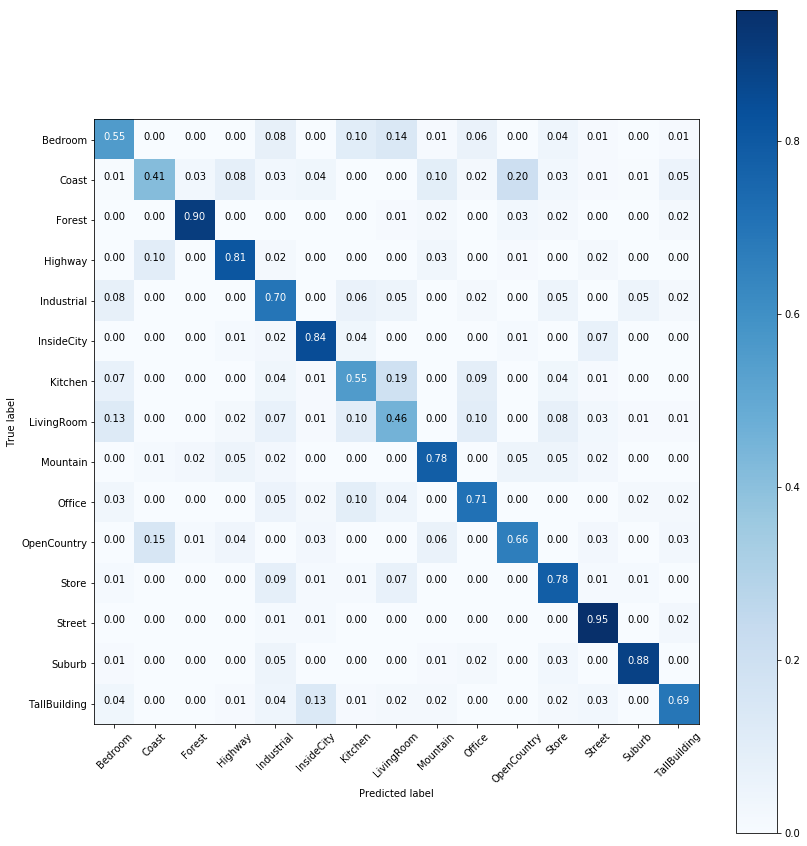

In [178]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")

    plt.imshow(cm, interpolation ='nearest', cmap = cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = "center",
                color ="white" if cm[i,j] > thresh else "black")
                   
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
c_names = []
for name in glob.glob('data/train/*'):
    c_names.append(name[11:])


#First combination:
# Confusion matrix
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Google Classroom. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Google Classroom and send emails only when it is private.

If you alter the folder strucutres, the grading of your PP will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from Google Classroom and unzip it (e.g. CSE327-PP3-Spring19.zip) <br>
2) The unzipped folder should have name like CSE327-PP3-Spring19, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>